# Customer Lifetime Value Project – EDA Notebook 🧠📊

## Objective 📌

This notebook performs exploratory data analysis (EDA) on the customer purchase dataset, focusing on RFM (Recency, Frequency, Monetary, AveragePurchaseValue, CustomerLifespan, MeanDaysBetweenPurchases) features and deriving Customer Lifetime Value (CLV).

The goal is to understand customer purchasing behavior to support further modeling (e.g., churn prediction, segmentation, CLV regression).

---

## 1. Load RFM Data

In [1]:
import sys
import os
os.chdir("..")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_preparation import prepare_data
from src.feature_engineering import engineer_features

# Load and clean data
purchases, survey = prepare_data.load_raw_data()
df_cleaned = prepare_data.clean_data(purchases)

# Define cutoff date for training vs future
cutoff_date = pd.Timestamp("2022-01-01")

# Split into past (features) and future (targets)
df_past = df_cleaned[df_cleaned["Order Date"] < cutoff_date]
df_future = df_cleaned[df_cleaned["Order Date"] >= cutoff_date]

# Create RFM features based on past data
rfm_df = engineer_features.create_rfm_features(df_past,
    customer_id_col='Survey ResponseID',
    invoice_date_col='Order Date',
    amount_col='TotalPrice'
)

# Create CLV targets from future data (e.g., 12 months window)
clv_df_per_window = engineer_features.create_clv_targets(df_cleaned,
    customer_id_col='Survey ResponseID',
    invoice_date_col='Order Date',
    amount_col='TotalPrice',
    cutoff_date=cutoff_date,
    window_months=12
)

clv_df_per_window = clv_df_per_window.rename(columns= {"FutureCLV" : "FutureCLVperWindow", "LogFutureCLV" : "LogFutureCLVperWindow"})

clv_df_common = engineer_features.create_clv_targets(df_cleaned,
    customer_id_col='Survey ResponseID',
    invoice_date_col='Order Date',
    amount_col='TotalPrice',
    cutoff_date=cutoff_date
)

# Merge features and target
merged_for_window = pd.merge(rfm_df, clv_df_per_window, on='Survey ResponseID', how='inner')
merged_df = pd.merge(merged_for_window, clv_df_common, on='Survey ResponseID', how='inner')
merged_df.head()

,Survey ResponseID,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases,FutureCLVperWindow,LogFutureCLVperWindow,FutureCLV,LogFutureCLV
0,R_01vNIayewjIIKMF,2,130,4502.83,34.637154,1123,8.638462,417.18,6.035912,417.18,6.035912
1,R_037XK72IZBJyF69,3,962,13754.37,14.297682,1443,1.500000,3835.52,8.252321,3835.52,8.252321
2,R_038ZU6kfQ5f89fH,40,64,3914.00,61.156250,1109,17.328125,333.54,5.812756,333.54,5.812756
3,R_03aEbghUILs9NxD,3,147,3333.72,22.678367,1448,9.850340,459.93,6.133246,549.26,6.310391
4,R_06RZP9pS7kONINr,3,328,8254.94,25.167500,1438,4.384146,2968.76,7.996236,2968.76,7.996236


In [3]:
merged_df.drop(columns=["FutureCLV", "LogFutureCLV"], inplace=True)
merged_df.rename(columns={
    "FutureCLVperWindow": "FutureCLV",
    "LogFutureCLVperWindow": "LogFutureCLV"
}, inplace=True)
merged_df.columns

Index(['Survey ResponseID', 'Recency', 'Frequency', 'Monetary',
       'AveragePurchaseValue', 'CustomerLifespan', 'MeanDaysBetweenPurchases',
       'FutureCLV', 'LogFutureCLV'],
      dtype='object')

In [4]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4991 entries, R_01vNIayewjIIKMF to R_zfqnsBzlOAKibzb
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Recency                   4991 non-null   int64  
 1   Frequency                 4991 non-null   int64  
 2   Monetary                  4991 non-null   float64
 3   AveragePurchaseValue      4991 non-null   float64
 4   CustomerLifespan          4991 non-null   int64  
 5   MeanDaysBetweenPurchases  4991 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 272.9+ KB


## 2. Summary Statistics

In [5]:
rfm_df.describe()

,Recency,Frequency,Monetary,AveragePurchaseValue,CustomerLifespan,MeanDaysBetweenPurchases
count,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000
mean,45.205971,274.206171,6491.449487,26.386309,1299.845121,22.784088
std,133.269954,324.065624,7415.891649,14.760126,282.330690,64.604775
min,0.000000,1.000000,4.990000,4.081090,1.000000,0.417885
25%,2.000000,64.000000,1559.820000,18.801478,1288.000000,3.771480
50%,9.000000,169.000000,4159.060000,23.536456,1434.000000,7.707447
75%,24.000000,363.000000,8675.880000,29.900969,1454.000000,18.467949
max,1460.000000,3489.000000,86965.850000,289.920000,1460.000000,1447.000000


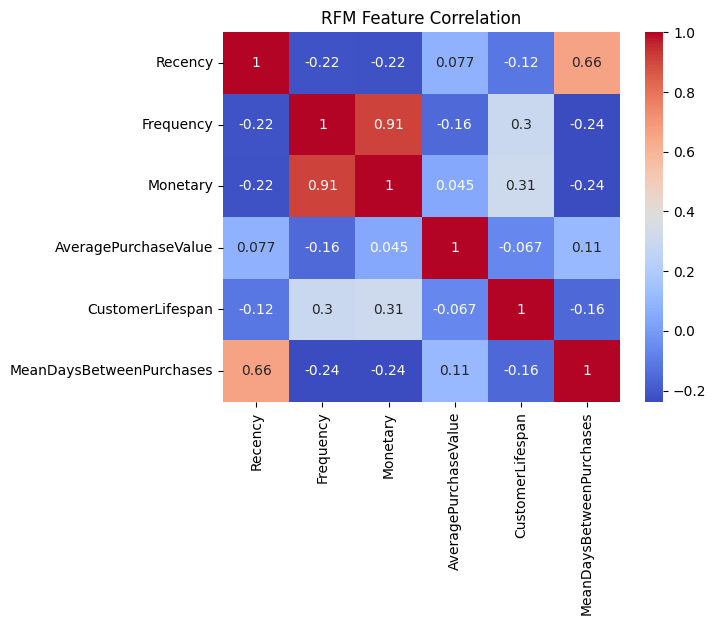

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(rfm_df.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlation")
plt.show()

## 3. Distributions

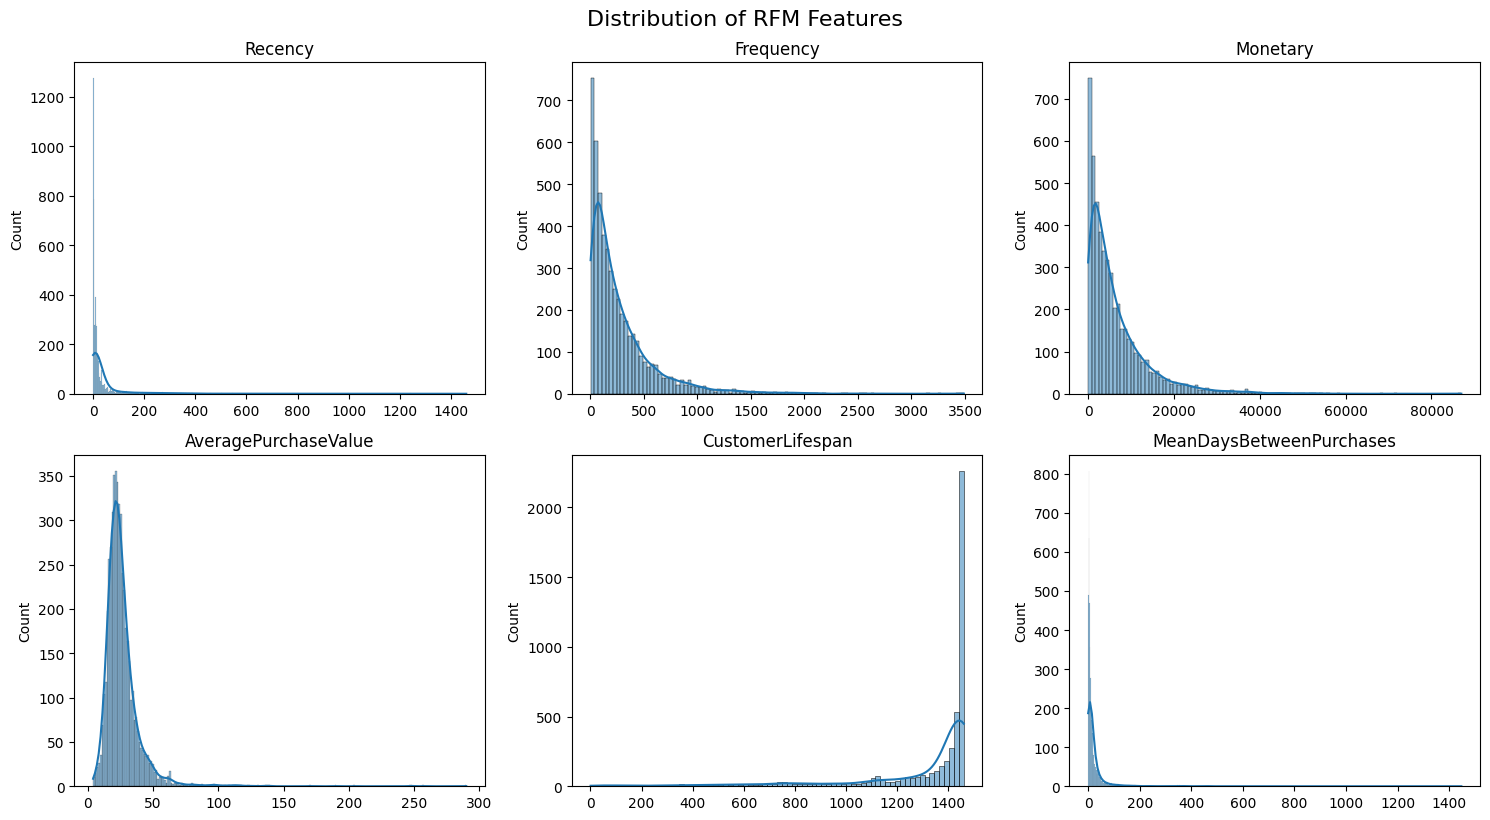

In [7]:
plt.figure(figsize=(15, 8))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_df[col], kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.tight_layout()

plt.suptitle("Distribution of RFM Features", fontsize=16, y=1.02)
plt.show()

## 4. Features outliers

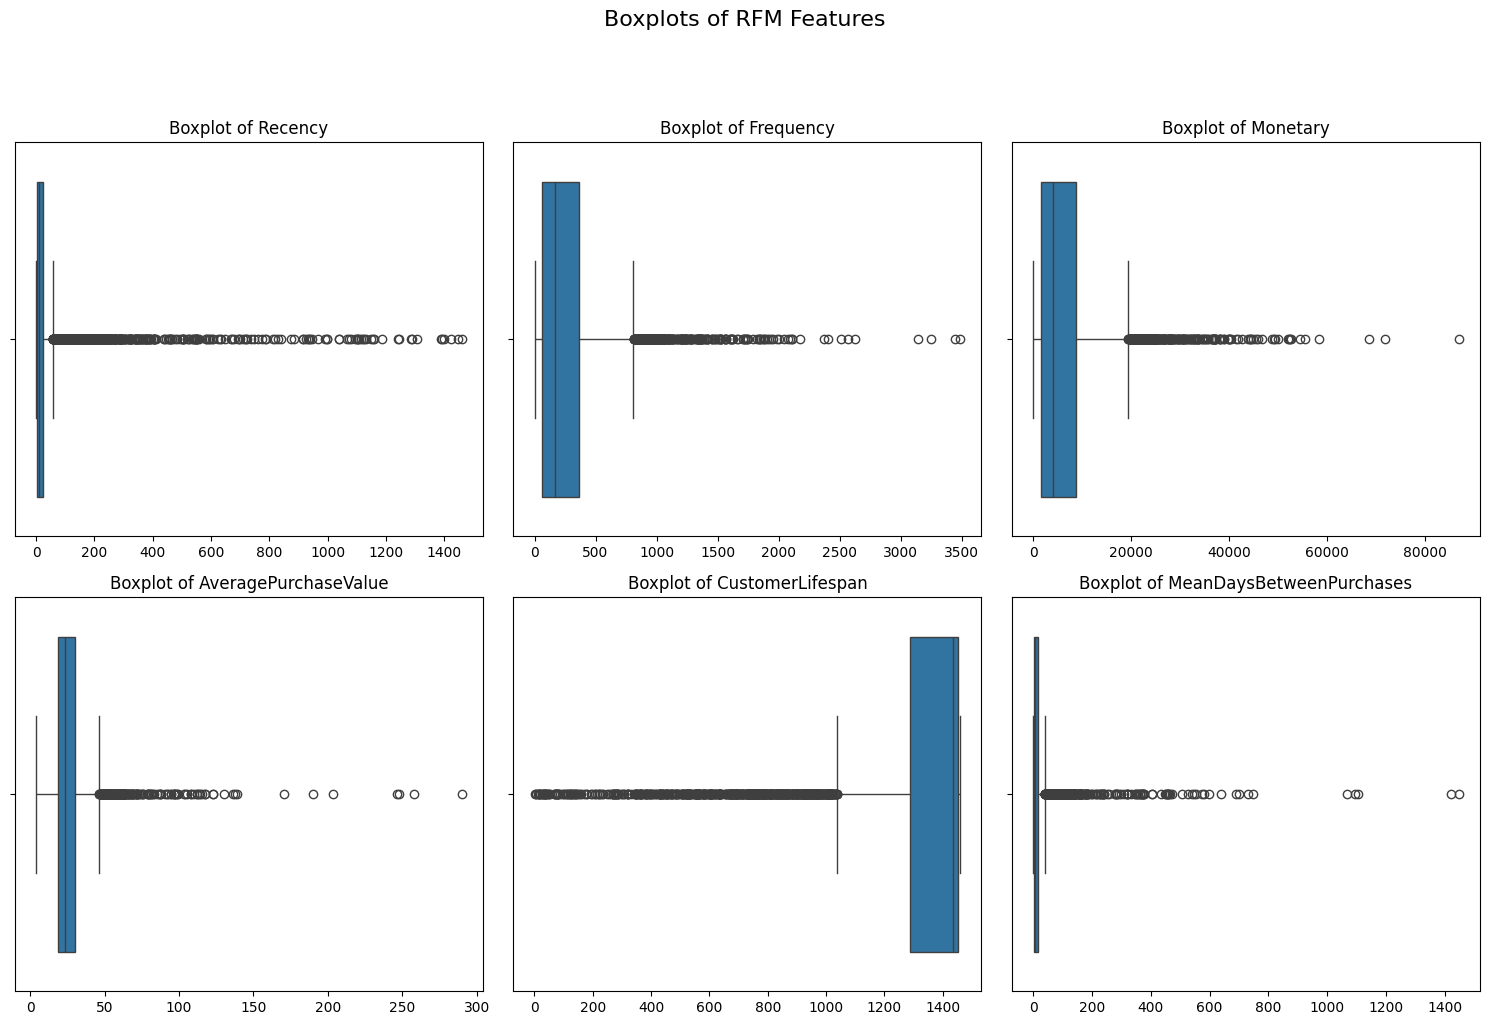

In [8]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(rfm_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=rfm_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.suptitle("Boxplots of RFM Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [9]:
import numpy as np

for col in rfm_df.columns:
    q1 = rfm_df[col].quantile(0.25)
    q3 = rfm_df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = rfm_df[(rfm_df[col] < (q1 - 1.5 * iqr)) | (rfm_df[col] > (q3 + 1.5 * iqr))]
    print(f'Outliers in {col}: {len(outliers)}')

Outliers in Recency: 692
Outliers in Frequency: 320
Outliers in Monetary: 301
Outliers in AveragePurchaseValue: 282
Outliers in CustomerLifespan: 645
Outliers in MeanDaysBetweenPurchases: 548


## 5. Feature Transformation

To address strong skewness and scale disparities among RFM features, we applied a mixed transformation strategy:

- **Logarithmic transformation** was applied to `Frequency`, `Monetary`, and `AveragePurchaseValue`, as they are strictly positive and heavily right-skewed.
- **Quantile transformation (normal output distribution)** was used for `Recency`, `CustomerLifespan`, and `MeanDaysBetweenPurchases`, which showed extreme skewness and high variance in scale. This method helps to approximate a normal distribution, making features more suitable for many machine learning models.

This combination balances interpretability and model-readiness.



In [10]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

# Копируем датафрейм
rfm_transformed = rfm_df.copy()

# 1. Log-transformation
log_cols = ['Frequency', 'Monetary', 'AveragePurchaseValue']
rfm_transformed[log_cols] = rfm_transformed[log_cols].apply(lambda x: np.log1p(x))

# 2. QuantileTransformer
skewed_cols = ['Recency', 'CustomerLifespan', 'MeanDaysBetweenPurchases']
qt = QuantileTransformer(output_distribution='normal', random_state=42)
rfm_transformed[skewed_cols] = qt.fit_transform(rfm_transformed[skewed_cols])


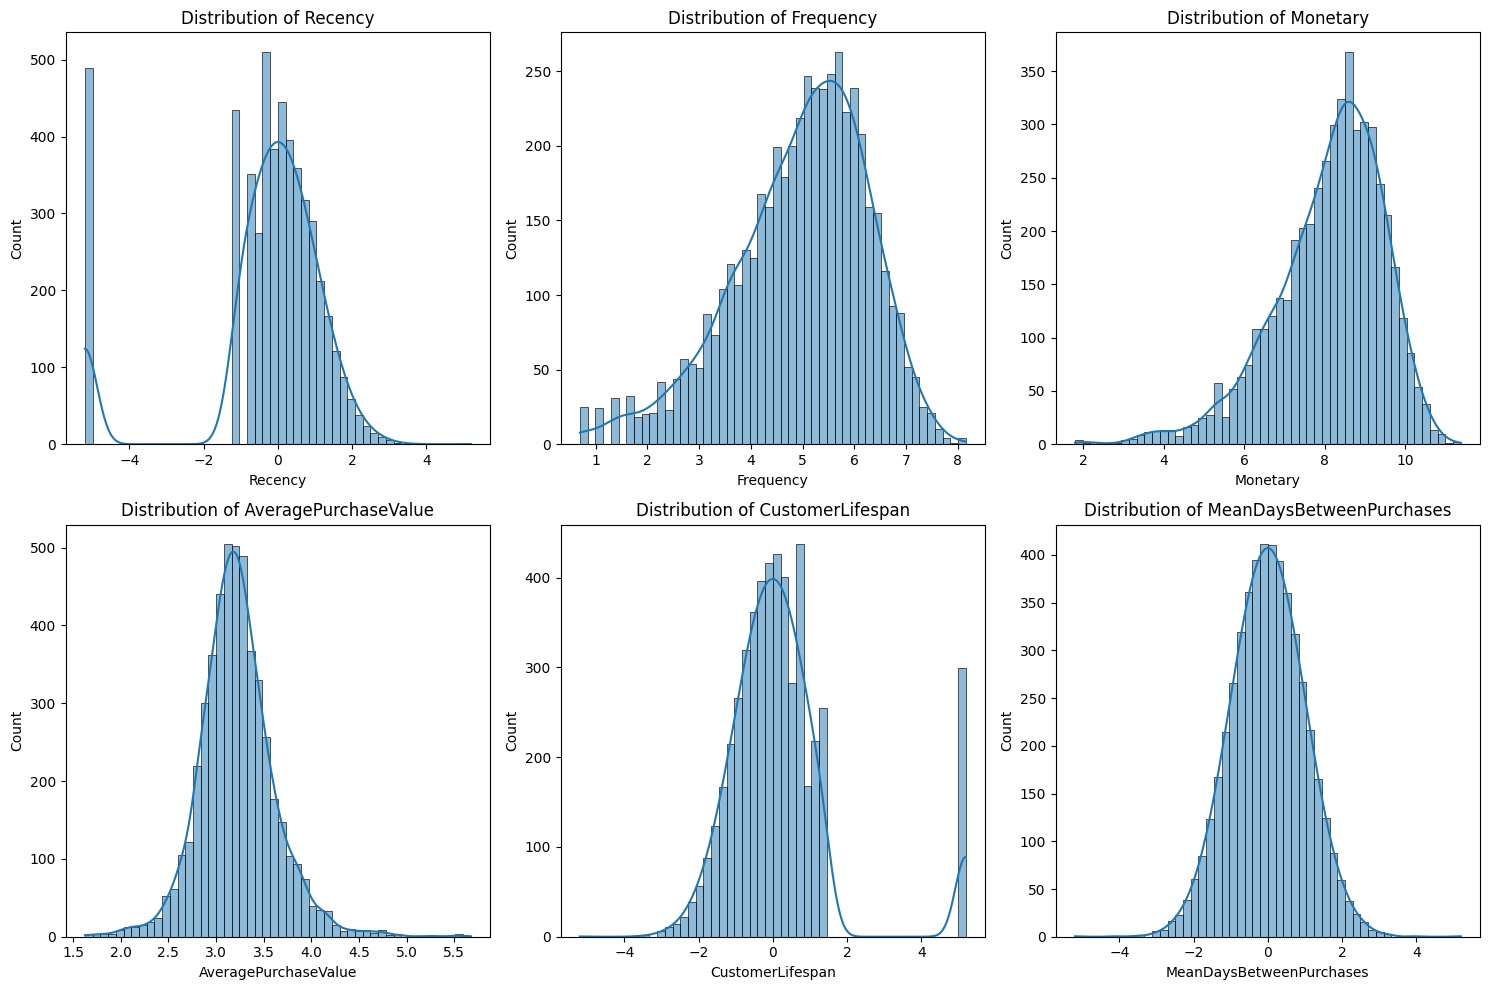

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(rfm_transformed.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(rfm_transformed[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Now we can check outliars

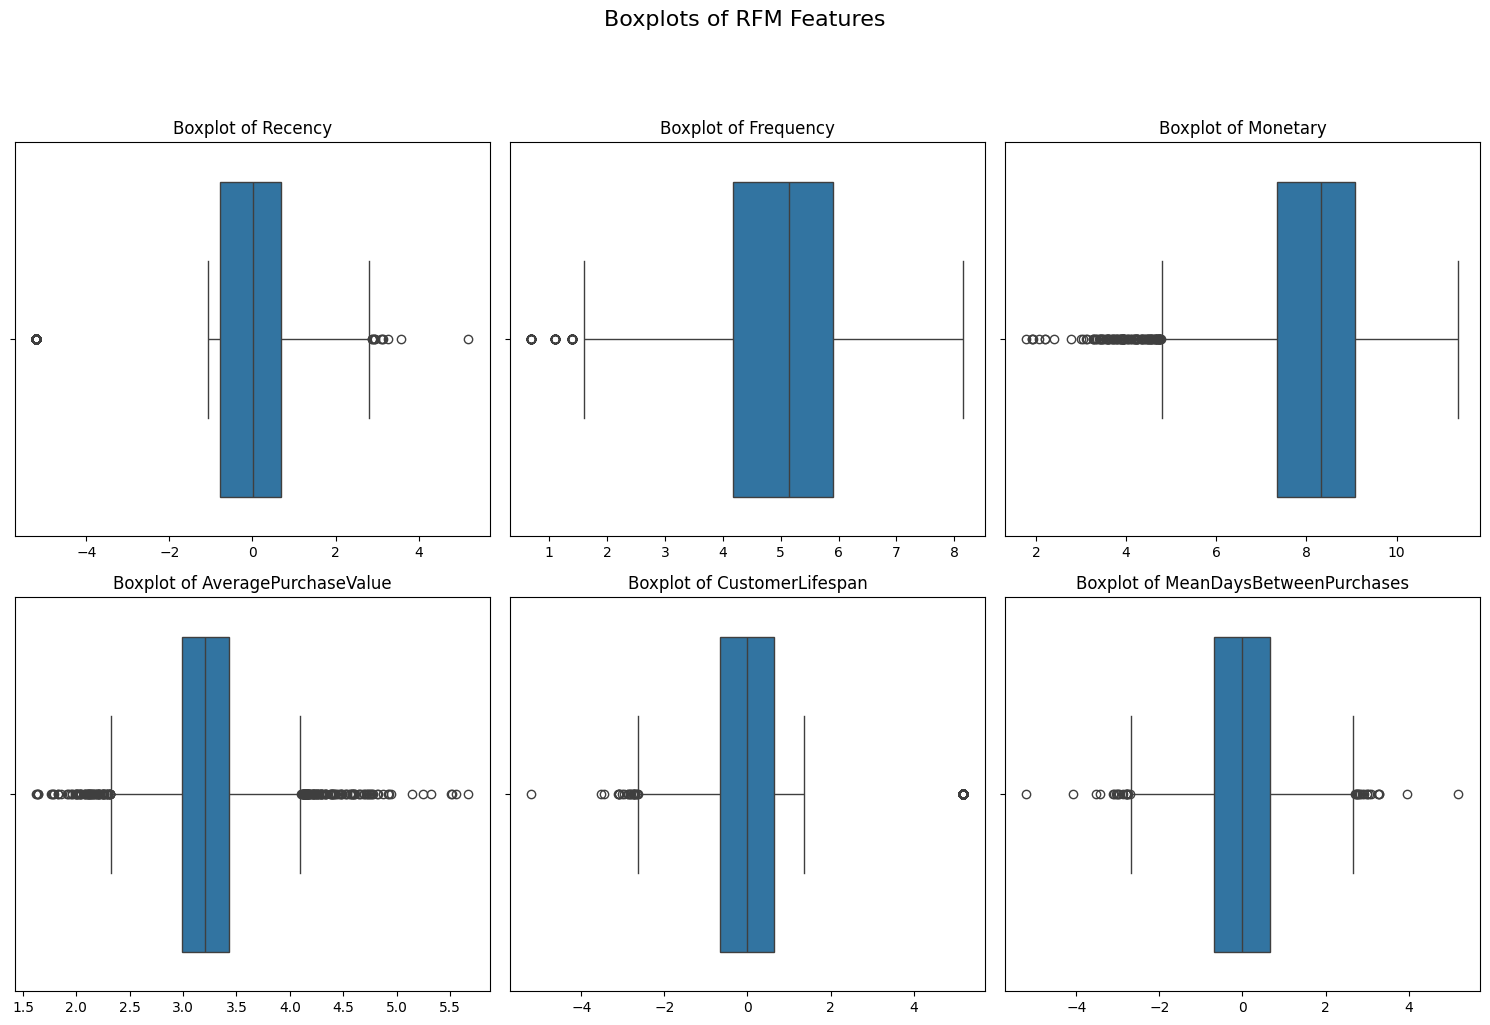

In [12]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(rfm_transformed.columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=rfm_transformed, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel("")

plt.suptitle("Boxplots of RFM Features", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## 6. Target Variable Analysis

To better understand the nature of our prediction target, we analyzed the distribution and correlation of **Customer Lifetime Value (CLV)** — defined as total customer spend after a selected cutoff date (`2022-01-01`). The raw CLV values were heavily skewed, so we applied a log(1 + x) transformation to improve normality and stabilize variance.

### Key Observations:
- The **log-transformed CLV** distribution is approximately normal with a single prominent mode.
- The strongest **correlations** with future CLV are:
  - `Monetary` (0.67)
  - `Frequency` (0.65)
  - `LogFutureCLV` (0.64)
  - `CustomerLifespan` (0.29)
- **Recency** and **MeanDaysBetweenPurchases** show moderate negative correlations, consistent with RFM theory (more recent/frequent buyers are more valuable).

This analysis confirms that historical RFM metrics can be good predictors of future customer value and justifies their inclusion as features in upcoming modeling steps.


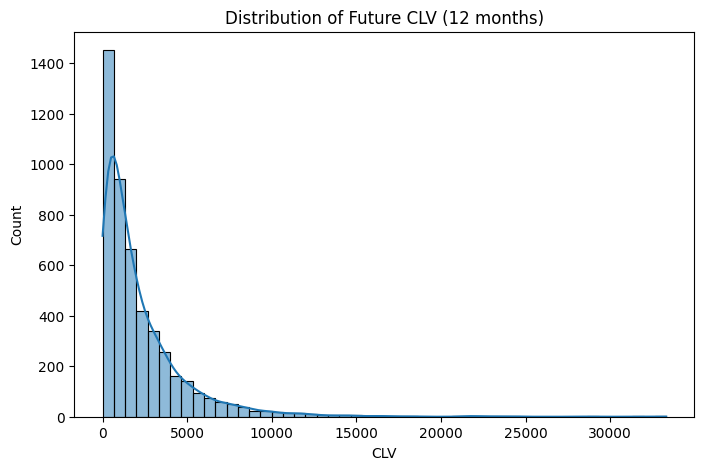

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['FutureCLV'], bins=50, kde=True)
plt.title('Distribution of Future CLV (12 months)')
plt.xlabel('CLV')
plt.ylabel('Count')
plt.show()

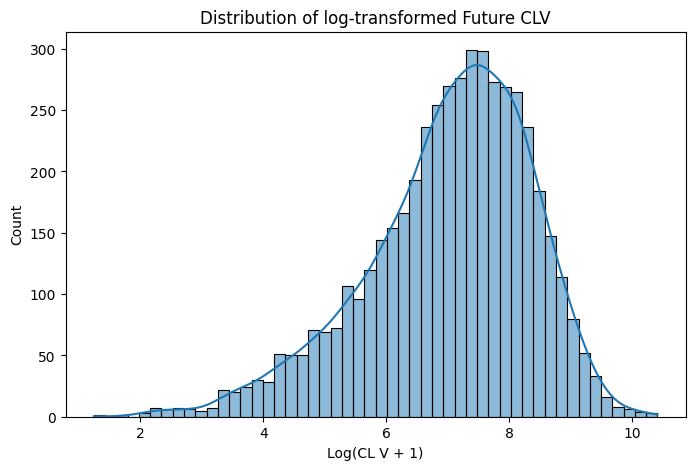

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['LogFutureCLV'], bins=50, kde=True)
plt.title('Distribution of log-transformed Future CLV')
plt.xlabel('Log(CL V + 1)')
plt.ylabel('Count')
plt.show()

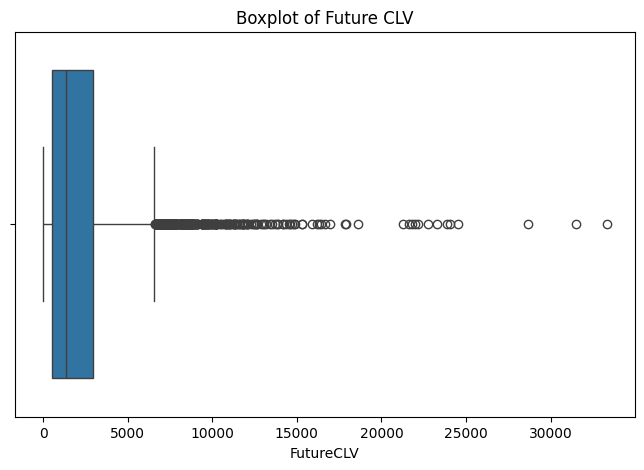

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_df['FutureCLV'])
plt.title('Boxplot of Future CLV')
plt.show()

In [16]:
print("Target Summary Statistics:")
print(merged_df["FutureCLV"].describe())

zero_clv_ratio = (merged_df["FutureCLV"] == 0).mean()
print(f"\nPercentage of customers with zero future CLV: {zero_clv_ratio:.2%}")

Target Summary Statistics:
count     4833.000000
mean      2211.325816
std       2677.756553
min          2.460000
25%        522.960000
50%       1354.430000
75%       2946.790000
max      33314.430000
Name: FutureCLV, dtype: float64

Percentage of customers with zero future CLV: 0.00%


### Target Variable

The target variable for our prediction task is `LogFutureCLV`, which represents the log-transformed Customer Lifetime Value for a 12-month window after the cutoff date (January 1, 2022). We drop the raw `FutureCLV` to avoid data leakage and simplify training.


In [17]:
merged_df.drop(columns=["FutureCLV"], inplace=True)

### Correlation Analysis

Below is a heatmap showing the Pearson correlation between engineered features and the target variable `LogFutureCLV`. This helps identify which behavioral metrics are most predictive of future value.

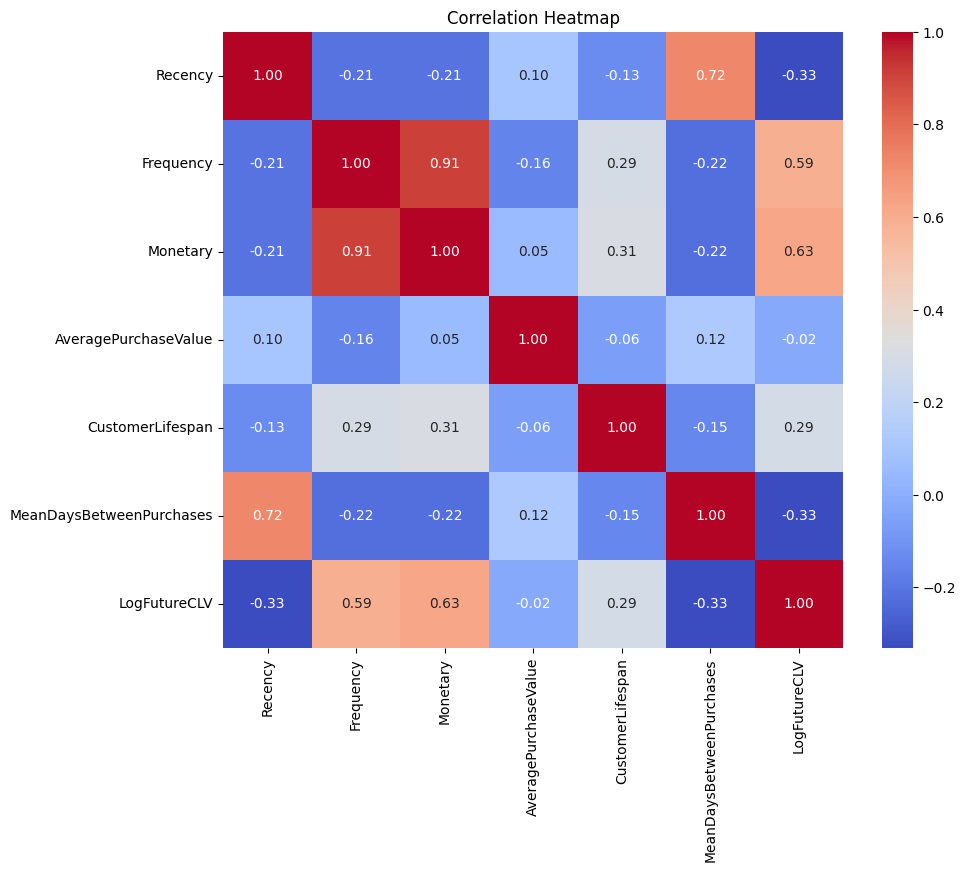

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## 7. Uploading Datase

In [19]:
merged_df.to_csv("data/processed/rfm_clv.csv", index=False)
print("Merged dataset saved to data/processed/rfm_clv.csv")

Merged dataset saved to data/processed/rfm_clv.csv
